# Importance Sampling Examples

In [1]:
from qmcpy import *
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

## Game Example

In [2]:
payoff = lambda x: 10*(x.sum(1)>1.7)
abs_tol = .001

In [3]:
## Without Importance Sampling
distribution = IIDStdUniform(2)
measure = Uniform(distribution)
integral = QuickConstruct(measure,payoff)
solution1,data1 = MeanMC_g(integral,abs_tol=abs_tol).integrate()
data1

Solution: 0.4501         
QuickConstruct (Integrand Object)
IIDStdUniform (Discrete Distribution Object)
	dimension       2
	seed            None
	mimics          StdUniform
Uniform (True TrueMeasure Object)
	distrib_name    IIDStdUniform
	lower_bound     0
	upper_bound     1
MeanMC_g (Stopping Criterion Object)
	inflate         1.200
	alpha           0.010
	abs_tol         0.001
	rel_tol         0
	n_init          1024
	n_max           10000000000
MeanVarData (AccumulateData Object)
	levels          1
	solution        0.450
	n               61964694
	n_total         61965718
	confid_int      [ 0.449  0.451]
	time_integrate  2.464

In [4]:
# With Importance Sampling
p = 1
distribution = IIDStdUniform(2)
measure = Uniform(distribution)
integral = QuickConstruct(measure,lambda x: payoff(x**(1/(p+1))) / ((p+1)**2 * (x.prod(1))**(p/(p+1))))
solution2,data2 = MeanMC_g(integral,abs_tol=abs_tol).integrate()
data2

Solution: 0.4501         
QuickConstruct (Integrand Object)
IIDStdUniform (Discrete Distribution Object)
	dimension       2
	seed            None
	mimics          StdUniform
Uniform (True TrueMeasure Object)
	distrib_name    IIDStdUniform
	lower_bound     0
	upper_bound     1
MeanMC_g (Stopping Criterion Object)
	inflate         1.200
	alpha           0.010
	abs_tol         0.001
	rel_tol         0
	n_init          1024
	n_max           10000000000
MeanVarData (AccumulateData Object)
	levels          1
	solution        0.450
	n               12910170
	n_total         12911194
	confid_int      [ 0.449  0.451]
	time_integrate  0.774

In [5]:
print('Imporance Sampling takes %.3f the time and %.3f the samples'%\
     (data2.time_integrate/data1.time_integrate,data2.n_total/data1.n_total))

Imporance Sampling takes 0.314 the time and 0.208 the samples


## Asian Call Option Example

In [16]:
abs_tol = .02
n_plt = 25
dimension = 32
time_vector = [i/dimension for i in range(1,dimension+1)]

In [17]:
# Without Importance Sampling
distribution = IIDStdGaussian(dimension)
measure = BrownianMotion(distribution,time_vector)
integrand = AsianCall(measure)
solution1,data1 = MeanMC_g(integrand,abs_tol=abs_tol).integrate()
data1

Solution: 1.7802         
AsianCall (Integrand Object)
	volatility      0.500
	start_price     30
	strike_price    35
	interest_rate   0
	mean_type       arithmetic
	_dim_frac       0
IIDStdGaussian (Discrete Distribution Object)
	dimension       32
	seed            None
	mimics          StdGaussian
BrownianMotion (True TrueMeasure Object)
	distrib_name    IIDStdGaussian
	time_vector     [ 0.031  0.062  0.094 ...  0.938  0.969  1.000]
MeanMC_g (Stopping Criterion Object)
	inflate         1.200
	alpha           0.010
	abs_tol         0.020
	rel_tol         0
	n_init          1024
	n_max           10000000000
MeanVarData (AccumulateData Object)
	levels          1
	solution        1.780
	n               768509
	n_total         769533
	confid_int      [ 1.760  1.800]
	time_integrate  1.775

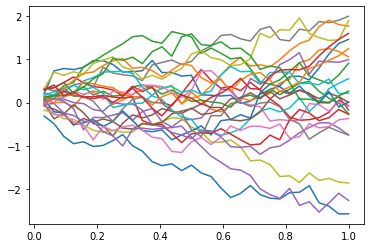

In [18]:
# Plot Samples
samples = measure.gen_mimic_samples(n_plt)
for i in range(n_plt):
    plt.plot(time_vector,samples[i])

In [25]:
# With Importance Sampling
mean_shift_is = 1
distribution = IIDStdGaussian(dimension)
measure = BrownianMotion(distribution,time_vector,mean_shift_is)
integrand = AsianCall(measure)
solution2,data2 = MeanMC_g(integrand,abs_tol=abs_tol).integrate()
data2

Solution: 1.7806         
AsianCall (Integrand Object)
	volatility      0.500
	start_price     30
	strike_price    35
	interest_rate   0
	mean_type       arithmetic
	_dim_frac       0
IIDStdGaussian (Discrete Distribution Object)
	dimension       32
	seed            None
	mimics          StdGaussian
BrownianMotion (True TrueMeasure Object)
	distrib_name    IIDStdGaussian
	time_vector     [ 0.031  0.062  0.094 ...  0.938  0.969  1.000]
MeanMC_g (Stopping Criterion Object)
	inflate         1.200
	alpha           0.010
	abs_tol         0.020
	rel_tol         0
	n_init          1024
	n_max           10000000000
MeanVarData (AccumulateData Object)
	levels          1
	solution        1.781
	n               161502
	n_total         162526
	confid_int      [ 1.761  1.801]
	time_integrate  0.821

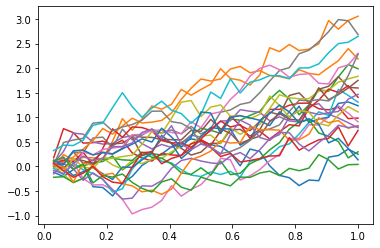

In [27]:
# Plot Samples
samples = measure.gen_mimic_samples(n_plt)
for i in range(n_plt):
    plt.plot(time_vector,samples[i])

In [26]:
print('Imporance Sampling takes %.3f the time and %.3f the samples'%\
     (data2.time_integrate/data1.time_integrate,data2.n_total/data1.n_total))

Imporance Sampling takes 0.462 the time and 0.211 the samples
